# cs7324 Lab 6 - Convolutional Neural Networks

#### Chip Henderson - 48996654 

Write something here about the dataset.

There were two I downloaded. One for binary:
https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset

And one for classification:
https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/code

## Preparation

In [591]:
# Source modified from in-class notebook
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

print('Tensorflow version:',tf.__version__)



Tensorflow version: 2.12.0


In [592]:
train_folders = r"C:\Users\Chip\source\repos\cs7324_code\Data_Sources\Brain_Tumor_Classification_datset\Training"
test_folders = r"C:\Users\Chip\source\repos\cs7324_code\Data_Sources\Brain_Tumor_Classification_datset\Testing"

# Source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
ds_train = tf.keras.utils.image_dataset_from_directory(
    train_folders,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=32, # changed from default 32
    image_size=(128, 128), # Downsample the images
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='gaussian',
    follow_links=False,
    crop_to_aspect_ratio=True
)

ds_test = tf.keras.utils.image_dataset_from_directory(
    test_folders,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=32, # changed from default 32
    image_size=(128, 128), # Downsample the images
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='gaussian',
    follow_links=False,
    crop_to_aspect_ratio=True
)

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


**Revisit this to see how we can make the labels appear as their string versions**

C:\Users\Chip\AppData\Local\Temp\ipykernel_15076\4196770863.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,4,i+1)


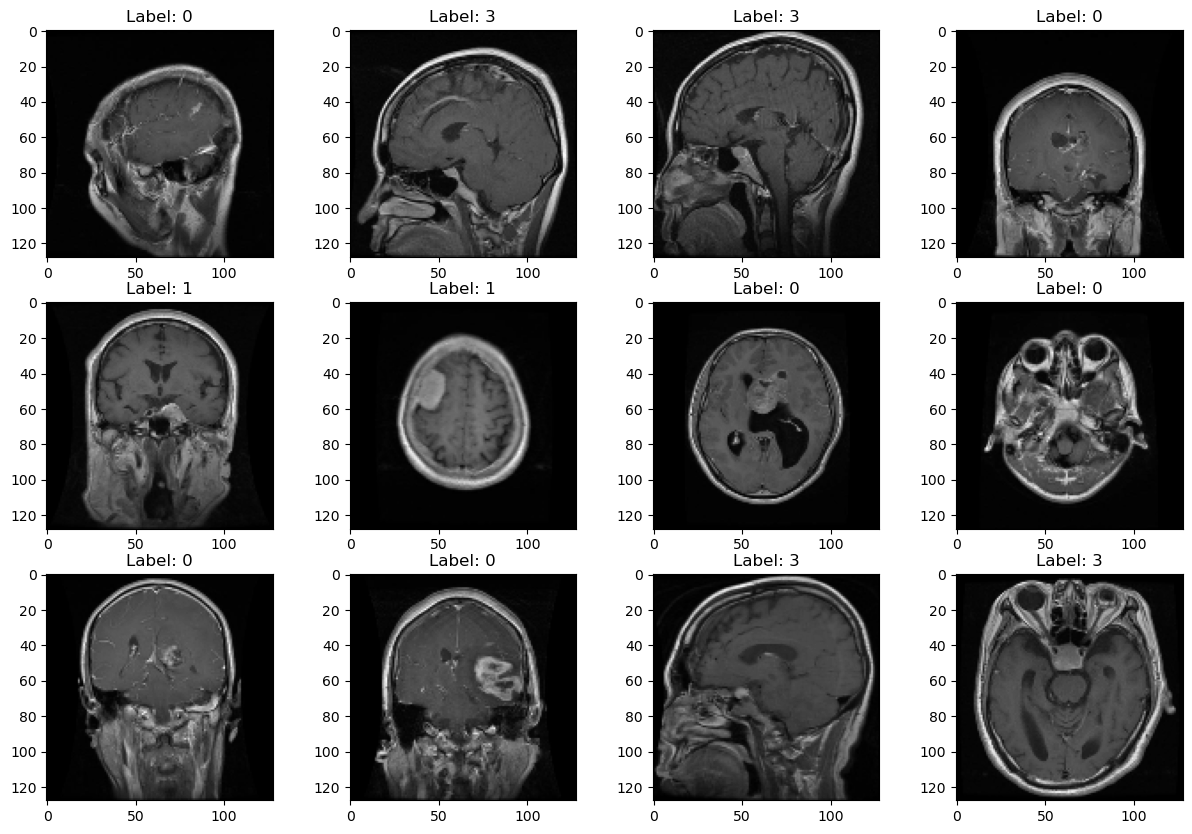

In [593]:
# Source: Code re-use from Lab 2 and 5

import matplotlib.pyplot as plt
class_names = ["Glioma", "Meningioma", "Healthy", "Pituitary"]

plt.subplots(figsize=(15, 10))

# Iterate through the dataset
for i, (images, labels) in enumerate(ds_train.take(12)):
    plt.subplot(3,4,i+1)
    # Display the first image in the batch
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    # label_str = class_names[labels[0].numpy()]
    plt.title(f"Label: {np.argmax(labels)}")
        
plt.show()

Let's check out the balance of samples.
ds_test

### Metrics

I fully expect this to be a very challenging dataset. Just looking at these images you have different orientations which will challenge the ability to reliably detect edges and locations. Where there are positive tumor detection, it is difficult to visually see the difference in what those types of tumors are. 

To think about this in greater detail, I'll discuss what I believe the business case of a model like this would be. Unlike my previous breast cancer dataset in lab 5, this model is not focused on the lethality of the cancer. This model should be able to relieve the burden on radiologists by identifying patients with tumors. A study in Applied Radiology in 2015 indicated that radiologists need to interpret one image every 3-4 seconds in an eight hour workday (https://appliedradiology.com/articles/the-radiologist-s-gerbil-wheel-interpreting-images-every-3-4-seconds-eight-hours-a-day-at-mayo-clinic#:~:text=That%20is%20what%20radiologists%20interpreting,seconds%20to%20meet%20workload%20demands). Some of these images which are displayed above allow for an easy visual assessment of wehther a tumor is present, many do not. So the intent of my model from a business case perspective, is to identify that a tumor is present, which can create a subset of patients for further detailed evaluation. This could help alleviate the burden on radiologists and identifying the specific class is simply added benefit.

With this in mind, now my concern becomes more focused on accidentally declaring a person with a tumor to be healthy, a false negative. So I'd prefer a metric that encourages more false positives so that only when confidence is very high that a patient is healthy, it doesn't receive a more detailed review. The metric that most closely aligns with this desire is recall, as it emphasizes performance of the model with respect to the true positive rate. 

#### Data Split

This dataset came pre-split in training and testing divisions. The total count of each is 2,870 training samples and 394 testing samples. I'd like to see how many of each category exists in my datasets.

The number of Glioma tumors in the training data is 826
The number of Meningioma tumors in the training data is 822
The number of Healthy scans in the training data is 395
The number of Pituitary tumors in the training data is 827

The number of Glioma tumors in the testing data is 100
The number of Meningioma tumors in the testing data is 115
The number of Healthy scans in the testing data is 105
The number of Pituitary tumors in the testing data is 74


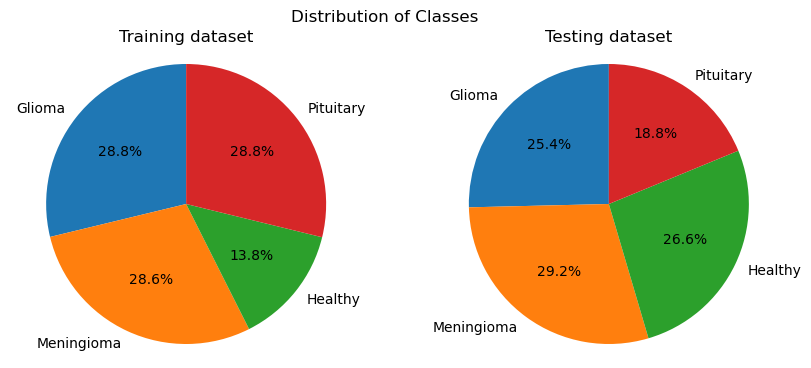

In [594]:
train_cancer_type = []
test_cancer_type = []

batches_train = [label.numpy().astype(int) for (image,label) in ds_train] # get training batches
batches_test = [label.numpy().astype(int) for (image,label) in ds_test] # get testing batches

# Get the individual cancer types from each dataset
for train_batch in batches_train:
    for train_label in train_batch:
        train_cancer_type.append(np.argmax(train_label))

for test_batch in batches_test:
    for test_label in test_batch:
        test_cancer_type.append(np.argmax(test_label))

print(f"The number of Glioma tumors in the training data is {train_cancer_type.count(0)}")
print(f"The number of Meningioma tumors in the training data is {train_cancer_type.count(1)}")
print(f"The number of Healthy scans in the training data is {train_cancer_type.count(2)}")
print(f"The number of Pituitary tumors in the training data is {train_cancer_type.count(3)}\n")

print(f"The number of Glioma tumors in the testing data is {test_cancer_type.count(0)}")
print(f"The number of Meningioma tumors in the testing data is {test_cancer_type.count(1)}")
print(f"The number of Healthy scans in the testing data is {test_cancer_type.count(2)}")
print(f"The number of Pituitary tumors in the testing data is {test_cancer_type.count(3)}")

# Plot the data usig a pie plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
pie_data = [train_cancer_type.count(0), train_cancer_type.count(1), train_cancer_type.count(2), train_cancer_type.count(3)]
plt.pie(pie_data, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Training dataset')

plt.subplot(1,2,2)
pie_data = [test_cancer_type.count(0), test_cancer_type.count(1), test_cancer_type.count(2), test_cancer_type.count(3)]
plt.pie(pie_data, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Testing dataset')

plt.suptitle('Distribution of Classes')

plt.show()

From the above chart I can see that there are more healthy samples in the testing dataset and fewer pituitary tumors. Also, to perform some basic math, my test/train split is roughly 88/12.

This distribution of values isn't terrible. Specifically, I'm not seeing a gross underrepresentation of one particular class. Still, this distribution may indicate I should look at performing a stratified KFold cross validation to ensure the balance differences seen between the classes are the same in my test and training data.

Let's take a look at combining and resplitting the data.

In [595]:
'''
# Source: Chat-GPT for info on combining datasets and implementing stratified_kfold after I'd selected it
# Note this is splitting based on batches of 32...
from sklearn.model_selection import StratifiedKFold

# Step 1: Combine the datasets
ds_combined = ds_train.concatenate(ds_test)
ds_combined = ds_combined.shuffle(buffer_size=len(ds_combined), seed=42, reshuffle_each_iteration=False)

# print(len(ds_combined))

# Step 2: Prepare labels for stratified k-fold
labels = []
for _, label in ds_combined.unbatch():
    labels.append(tf.argmax(label).numpy())
labels = np.array(labels)

# Step 3: Perform stratified k-fold cross-validation

kfold_splits = 8  # 3,264 total images, each fold has 272 images with 12 or 408 with 8
stratified_kfold = StratifiedKFold(n_splits=kfold_splits, shuffle=True, random_state=5)

for fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(np.zeros(len(labels)), labels)):
    train_dataset = ds_combined.skip(len(ds_combined) // kfold_splits)
    train_dataset = train_dataset.take(len(train_dataset) * (kfold_splits - 1) // kfold_splits)
    
    validation_dataset = ds_combined.take(len(ds_combined) // kfold_splits)

    # Train your model using train_dataset and validate using validation_dataset
    # ...

    print(f"Fold {fold + 1}: Training on {len(train_dataset)} samples, validating on {len(validation_dataset)} samples")
'''


'\n# Source: Chat-GPT for info on combining datasets and implementing stratified_kfold after I\'d selected it\n# Note this is splitting based on batches of 32...\nfrom sklearn.model_selection import StratifiedKFold\n\n# Step 1: Combine the datasets\nds_combined = ds_train.concatenate(ds_test)\nds_combined = ds_combined.shuffle(buffer_size=len(ds_combined), seed=42, reshuffle_each_iteration=False)\n\n# print(len(ds_combined))\n\n# Step 2: Prepare labels for stratified k-fold\nlabels = []\nfor _, label in ds_combined.unbatch():\n    labels.append(tf.argmax(label).numpy())\nlabels = np.array(labels)\n\n# Step 3: Perform stratified k-fold cross-validation\n\nkfold_splits = 8  # 3,264 total images, each fold has 272 images with 12 or 408 with 8\nstratified_kfold = StratifiedKFold(n_splits=kfold_splits, shuffle=True, random_state=5)\n\nfor fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(np.zeros(len(labels)), labels)):\n    train_dataset = ds_combined.skip(len(ds_combi

## Modeling

In [596]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model

For the first model, I need to provide a data augmentation technique. In order to better understand the impact of such additions, I'd like to visualize some of the results of their application. 

C:\Users\Chip\AppData\Local\Temp\ipykernel_15076\3780908595.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 3, i + 1)


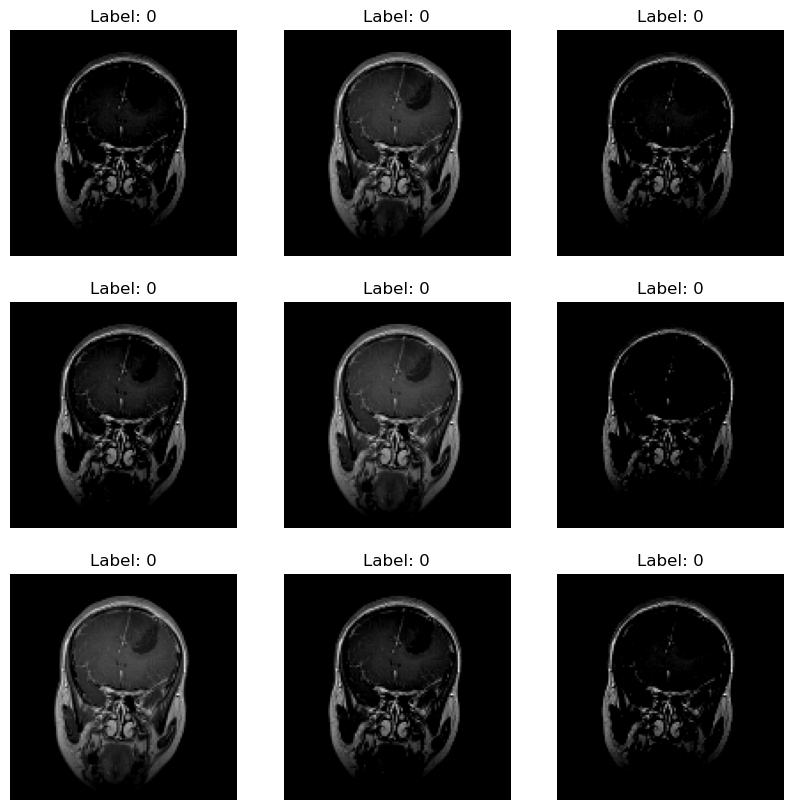

In [597]:
# Source: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

# from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
# from tensorflow.keras.layers import RandomContrast, RandomBrightness

img_augmentation = Sequential(
    [
        # layers.RandomRotation(factor=0.15),
        # layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        # layers.RandomFlip(),
        layers.RandomBrightness(factor=(-0.3,0)),
        layers.RandomContrast(factor=0.2)
    ],
    name="img_augmentation",
)

plt.subplots(figsize=(10, 10))
for i, (images, labels) in enumerate(ds_train.take(1)):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(images[0], axis=0))
        plt.imshow(aug_img.numpy().squeeze(), cmap='gray')
        # plt.imshow(images[0].numpy().squeeze(), cmap='gray')
        plt.title(f"Label: {np.argmax(labels)}")
        plt.axis("off")

Here, I'm focusing on brightness and contrast. Based on a review of the images in the dataset, many times the tumor indications show up very brightly. My hope is that by adjusting the contrast and the brightness I can further emphasize deliniations between healthy tissue and tumors.

Most of the images in the dataset are relatively bright. Therefore I selected a range (min,max) values which would darken the images. This Should improve performance because brigheter artifacts like the tumors and skull aren't as severely affected by dimming the image. Conversely, normal brain tissue which typically shows up in varrying shades of gray on the scans, will be significantly darkened. I anticipate that this will allow the model to identify edges more clearly which could help with diagnosis.

I also experimented with contrast, but found the results to be somewhat minimal visually no matter the factor used. So I'm using a random implementation her for that value.

In [598]:
# Source: in class lecture
# I'll use this function repeatedly throughout the lab
from sklearn import metrics as mt
from matplotlib import pyplot as plt
# from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, ds_test, title_text=''):
    plt.figure(figsize=(15,5))
    # convert dataset to test set we can use with sklearn.metrics
    y_test = tf.concat([tf.argmax(y,axis=1) for x, y in ds_test], axis=0)
    y_test = y_test.numpy()
    
    yhat = np.argmax(net.predict(ds_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat.squeeze())
    cm = mt.confusion_matrix(y_test,yhat.squeeze())
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=class_names,yticklabels=class_names)
    plt.title(f'{title_text} {acc:.4f}')
    

#### Model 1 Architecture 1

In [599]:
%%time
# Source: Modified from notebook 12a

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.layers import RandomContrast, RandomBrightness
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2 

NUM_CLASSES = 4
cnn_1 = Sequential()

# add in augmentations directly
cnn_1.add( RandomBrightness(factor=(-0.3,0)) )
cnn_1.add( RandomContrast(factor=0.2) )

# let's start with an AlexNet style convolutional phase
cnn_1.add(Conv2D(filters=32,
                input_shape = (128,128),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
cnn_1.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
                
cnn_1.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn_1.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn_1.add(Flatten())
cnn_1.add(Dense(64, activation='relu'))
cnn_1.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn_1.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn_1.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['Recall'])

cnn_1.build((None,128,128,1))

cnn_1.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_30 (Rando  (None, 128, 128, 1)      0         
 mBrightness)                                                    
                                                                 
 random_contrast_47 (RandomC  (None, 128, 128, 1)      0         
 ontrast)                                                        
                                                                 
 conv2d_40 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 conv2d_41 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                     

In [600]:
%%time 

# the shape of input (batch x h x w x channels)
# print(X_train.shape)

# Let's train the model 
# cnn_1.compile(loss='mean_squared_error',
#               optimizer='adam',
#               metrics=['Recall'])

history_cnn_1 = cnn_1.fit(
        ds_train,
        batch_size=32,
        epochs=15,
        verbose=1,
        validation_data=ds_test
        )

Epoch 1/15


90/90 [==============================] - 71s 756ms/step - loss: 21.1146 - recall: 0.1599 - val_loss: 4.4168 - val_recall: 0.2690
Epoch 2/15
90/90 [==============================] - 68s 754ms/step - loss: 1.1790 - recall: 0.3307 - val_loss: 2.5733 - val_recall: 0.1548
Epoch 3/15
90/90 [==============================] - 69s 766ms/step - loss: 0.9041 - recall: 0.5303 - val_loss: 2.7881 - val_recall: 0.3655
Epoch 4/15
90/90 [==============================] - 69s 759ms/step - loss: 0.7180 - recall: 0.6540 - val_loss: 2.2238 - val_recall: 0.4442
Epoch 5/15
90/90 [==============================] - 73s 808ms/step - loss: 0.5862 - recall: 0.7139 - val_loss: 2.6604 - val_recall: 0.4365
Epoch 6/15
90/90 [==============================] - 73s 811ms/step - loss: 0.5347 - recall: 0.7721 - val_loss: 5.6667 - val_recall: 0.4746
Epoch 7/15
90/90 [==============================] - 73s 808ms/step - loss: 0.4388 - recall: 0.8244 - val_loss: 3.6274 - val_recall: 0.4949
Epoch 8/15
90/90 [===================

What I'm getting out of it his initial MLP for this data is what I expected. With an accuracy of ~29% the model is doing only marginally better than chance. This is expected for a few reasons. As I mentioned previously this is a difficult dataset. This MLP model is just about as simple as sit gets, a pretty blunt tool for this kind of work. Throughout the next few models I'm going to try and improve on this result. However, I expect some limitations based on my hardware which is a Microsoft Surface Pro 8. 

What this dataset probably needs is something on the sophistication level of ResNet50. However running that model would take a very long time with my system and I'd like to see how much improvement I can get on this basic MLP with just some CNNs and augmentations.

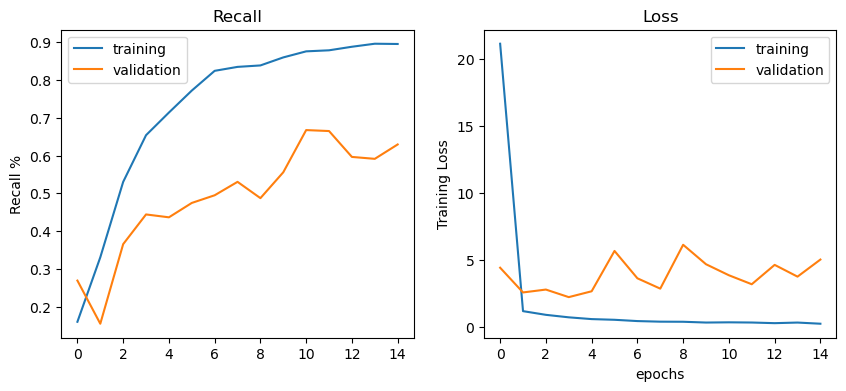

In [601]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_cnn_1.history['recall'], label='training')

plt.ylabel('Recall %')
plt.title('Training')
plt.plot(history_cnn_1.history['val_recall'], label='validation')
plt.title('Recall')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn_1.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history_cnn_1.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
#plt.show()

13/13 [==============================] - 3s 149ms/step


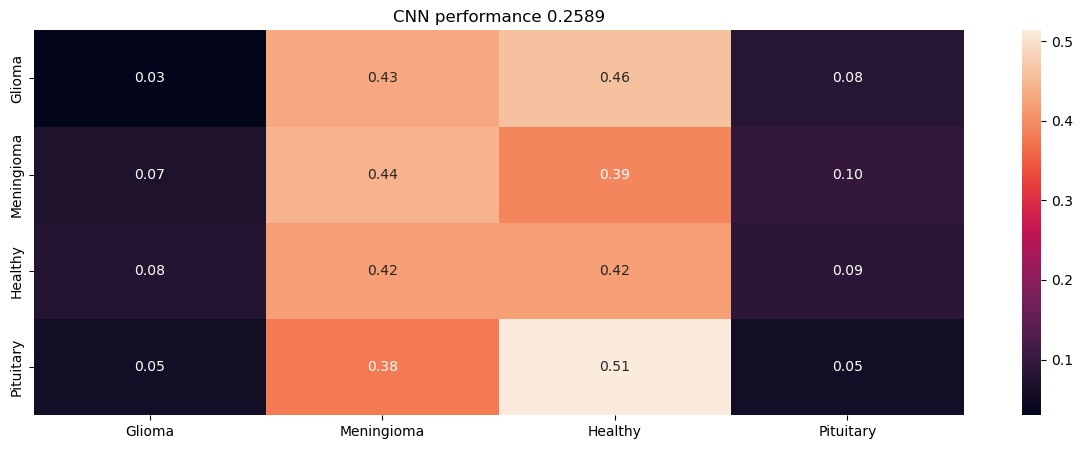

In [602]:
summarize_net(cnn_1, ds_test, title_text='CNN performance')

What I'm looking for in my confusion matrix to support my metric of recall is how many times I have a tumor in the image, Glioma, Meningioma, Pituitary, on the left hand side that is miscategorized as healthy on the bottom side. And in this case that appears to be very rare. While that's good for not letting False Negatives through, I'm concerned that this doesn't help alleviate the burden on radiologists which is really the intent of my model.

#### Model 2 Architecture 2

In [603]:
%%time
# Copy TensorFlow Architecture from 
#   Deep MNIST for experts
#   https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

# Manipulated to mirror parts of this network:
#   http://ankivil.com/mnist-database-and-simple-classification-networks/

cnn_2 = Sequential()

num_filt_layers = [32, 64]
for num_filters in num_filt_layers:
    cnn_2.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu',
                    ) ) # more compact syntax

    # max pooling
    cnn_2.add( MaxPooling2D(pool_size=(3, 3) ) ) # changed from 2, 2
    

# add one layer on flattened output
cnn_2.add( Dropout(0.25) ) # add some dropout for regularization after conv layers
cnn_2.add( Flatten() )
cnn_2.add( Dense(256, activation='relu') )
cnn_2.add( Dropout(0.5) ) # add some dropout for regularization, again!
cnn_2.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn_2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['Recall'])

input_shape = [None, 128,128,1]
cnn_2.build(input_shape)
print(cnn_2.summary())

history_cnn_2 = cnn_2.fit(ds_train,
            batch_size=32, epochs=30, 
            shuffle=True, verbose=1,
            validation_data=(ds_test))



Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 42, 42, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 42, 42, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 flatten_30 (Flatten)        (None, 12544)           

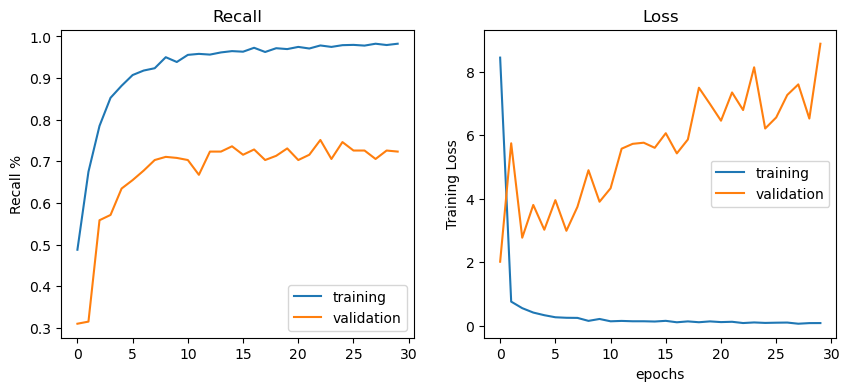

In [604]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_cnn_2.history['recall'], label='training')

plt.ylabel('Recall %')
plt.title('Training')
plt.plot(history_cnn_2.history['val_recall'], label='validation')
plt.title('Recall')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn_2.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history_cnn_2.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

In [605]:
'''
from sklearn import metrics as mt
from matplotlib import pyplot as plt
# from skimage.io import imshow
import seaborn as sns
%matplotlib inline

# labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
def summarize_net(net, ds_test, title_text=''):
    plt.figure(figsize=(15,5))
    # convert dataset to test set we can use with sklearn.metrics
    y_test = tf.concat([tf.argmax(y,axis=1) for x, y in ds_test], axis=0)
    y_test = y_test.numpy()
    
    yhat = np.argmax(net.predict(ds_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat.squeeze())
    cm = mt.confusion_matrix(y_test,yhat.squeeze())
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=class_names,yticklabels=class_names)
    plt.title(f'{title_text} {acc:.4f}')
'''
    

'\nfrom sklearn import metrics as mt\nfrom matplotlib import pyplot as plt\n# from skimage.io import imshow\nimport seaborn as sns\n%matplotlib inline\n\n# labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]\ndef summarize_net(net, ds_test, title_text=\'\'):\n    plt.figure(figsize=(15,5))\n    # convert dataset to test set we can use with sklearn.metrics\n    y_test = tf.concat([tf.argmax(y,axis=1) for x, y in ds_test], axis=0)\n    y_test = y_test.numpy()\n    \n    yhat = np.argmax(net.predict(ds_test), axis=1)\n    acc = mt.accuracy_score(y_test,yhat.squeeze())\n    cm = mt.confusion_matrix(y_test,yhat.squeeze())\n    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]\n    sns.heatmap(cm, annot=True, fmt=\'.2f\', xticklabels=class_names,yticklabels=class_names)\n    plt.title(f\'{title_text} {acc:.4f}\')\n'

13/13 [==============================] - 1s 47ms/step


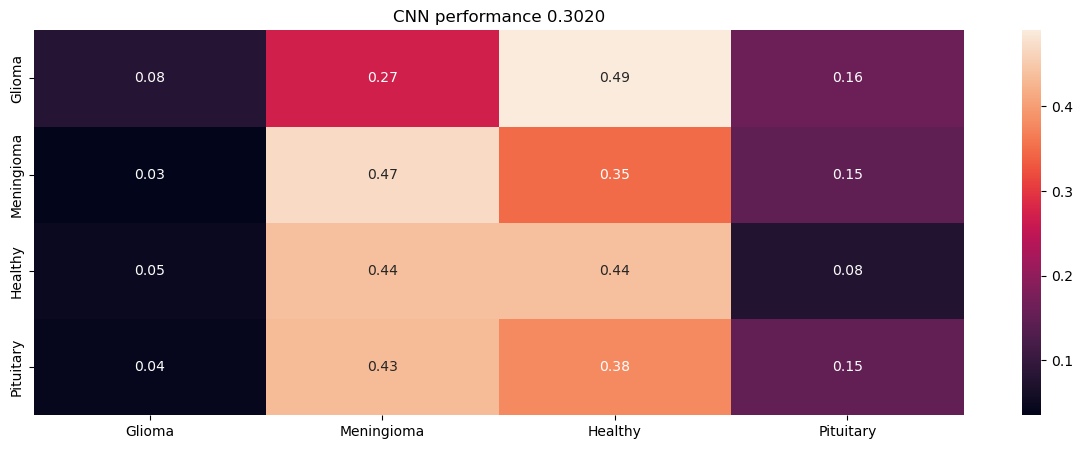

In [606]:
summarize_net(cnn_2, ds_test, title_text='CNN performance')

In [607]:
cnn_2.evaluate(ds_test, verbose=0)

[8.88592529296875, 0.7233502268791199]

In [608]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title(f'CNN: {acc_cnn:.4f}')
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title(f'MLP: {acc_mlp:.4f}')

In [609]:
compare_mlp_cnn(cnn_2,None,ds_test,ds_test,class_names)

13/13 [==============================] - 1s 40ms/step


ValueError: Found input variables with inconsistent numbers of samples: [13, 394]

<Figure size 1500x500 with 0 Axes>